## Train a `LinearRegression` model

In the attached workspace, you will read in some data from a file, and split it into training and test sets. (You may find it helpful to refer to the documentation for [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for this part.)

Then, you will fit a **LinearRegression** (using the **sklearn** implementation, you may refer to its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) on the training set, and evaluate its performance on the test set.


| Name	| Type | Description |
| --- | --- | --- |
**Xtr**	| pandas dataframe	| Training data - features.
**Xts**	| pandas dataframe	| Test data - features.
**ytr**	| pandas series OR pandas data frame OR 1d numpy array	| Training data - target variable.
**yts**	| pandas series OR pandas data frame OR 1d numpy array	| Test data - target variable.
**yts_hat**	| 1d | numpy array	| Model prediction for test data.
**rsq**	| float	| R2 of model on test data.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In this question, we will try to predict the number of bicycle trips across the Fremont Bridge in Seattle, WA using weather, season, and other factors as potential predictive features.

First, we'll load two datasets - a dataset of bike trips and a dataset of weather from October 2012 through August 2015- indexing by date:

In [2]:
bike = pd.read_csv('FremontBridge.csv', index_col='Date', date_format='%m/%d/%Y %I:%M:%S %p')
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, date_format='%Y%m%d')

You can add some code here to inspect the data, see the names of features, and see the data types - the cell below will not be graded.

In [3]:
bike
# weather

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0
...,...,...,...
2015-08-31 19:00:00,171.0,59.0,112.0
2015-08-31 20:00:00,57.0,33.0,24.0
2015-08-31 21:00:00,46.0,22.0,24.0


We will do some further processing on this dataset in preparation for training a model. We will construct a new data frame, with the target variable and the features that we will use.

First, we will prepare the target variable - the value we want to predict - the `Total` number of bike trips per day, -in a new data frame called `daily_bike`.

In [4]:
daily_bike = bike.resample('d').sum()
daily_bike = daily_bike[['Fremont Bridge Total']] # remove other columns
daily_bike

,Fremont Bridge Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0
...,...
2015-08-27,4336.0
2015-08-28,2653.0
2015-08-29,699.0


Right now, this data frame only has the target variable. Next, we'll prepare some features and add them to this `daily_bike` data frame.

First, since bike traffic patterns vary by day of the week, we will add a binary variable corresponding to each day of the week:

In [5]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily_bike[days[i]] = (daily_bike.index.dayofweek == i).astype(float)
daily_bike

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2015-08-27,4336.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-08-28,2653.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-08-29,699.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Another relevant feature might be the number of daylight hours. The following cell uses a standard astronomical calculation to add this information to `daily_bike`:

In [6]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily_bike['daylight_hrs'] = list(map(hours_of_daylight, daily_bike.index))
daily_bike

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,daylight_hrs
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.277359
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.219142
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.161038
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.103056
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.045208
...,...,...,...,...,...,...,...,...,...
2015-08-27,4336.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.474738
2015-08-28,2653.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.418591
2015-08-29,699.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.362212


Now we'll add some weather features!

* average temperature (in degrees celsius)
* total precipitation (in inches)
* a binary variable indicating whether the day is dry (zero precipitation) or not

In [7]:
# temperatures are given in 1/10 deg C, so this converts to deg C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['temp_c'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precipitation is given in 1/10 mm, this converts to inches
weather['precip_in'] = weather['PRCP']/254

# this indicates whether the day is dry - zero precipitation - or not
weather['dry_day'] = (weather['precip_in'] == 0).astype(int)

daily_bike = daily_bike.join(weather[['precip_in', 'temp_c', 'dry_day']])
daily_bike

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,daylight_hrs,precip_in,temp_c,dry_day
Date,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.277359,0.000000,13.35,1
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.219142,0.000000,13.60,1
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.161038,0.000000,15.30,1
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.103056,0.000000,15.85,1
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.045208,0.000000,15.85,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-27,4336.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.474738,0.000000,21.90,1
2015-08-28,2653.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.418591,0.019685,19.45,0
2015-08-29,699.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.362212,1.279528,17.75,0


Finally, we'll add a counter that just increases every day. This will help us see if there is a general trend over time, e.g. if bike riding is becoming more or less popular in general over the duration of this data.

In [8]:
daily_bike['counter'] = (daily_bike.index - daily_bike.index[0]).days / 365.
daily_bike

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,daylight_hrs,precip_in,temp_c,dry_day,counter
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.277359,0.000000,13.35,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.219142,0.000000,13.60,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.161038,0.000000,15.30,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.103056,0.000000,15.85,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.045208,0.000000,15.85,1,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-27,4336.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.474738,0.000000,21.90,1,2.898630
2015-08-28,2653.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.418591,0.019685,19.45,0,2.901370
2015-08-29,699.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.362212,1.279528,17.75,0,2.904110


You can add some code here to inspect `daily_bike` - the cell below will not be graded.

In [9]:
daily_bike.describe()

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,daylight_hrs,precip_in,temp_c,dry_day,counter
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2633.056444,0.142992,0.142051,0.142992,0.142992,0.142992,0.142992,0.142992,11.991777,0.115340,12.563688,0.585136,1.454795
std,1253.138245,0.350229,0.349267,0.350229,0.350229,0.350229,0.350229,0.350229,2.645034,0.259108,6.095843,0.492930,0.841112
min,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.218894,0.000000,-3.800000,0.000000,0.000000
25%,1806.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.401728,0.000000,8.050000,0.000000,0.727397
50%,2435.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.952145,0.000000,11.650000,1.000000,1.454795
75%,3574.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.604167,0.098425,17.750000,1.000000,2.182192
max,6088.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.781095,2.200787,26.700000,1.000000,2.909589


Now it's time to split this `daily_bike` data into training and test sets, using `train_test_split`! 

The following cell should 

* create `X` as a pandas data frame by selecting a list of columns from `daily_bike`. (Use the same column order as in `daily_bike`.)
* create `y` as a pandas data frame, pandas series, or numpy array containing the target variable. (Any of these formats are acceptable.)
* create `Xtr`. `Xts`, `ytr` and `yts` using `train_test_split`. Reserve 300 samples for testing. (Note that this is time series data, and it is ordered by time. It would *not* be appropriate to shuffle this data, so you should pass `shuffle=False`.)

In [10]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# Xtr = ...
# Xts = ...
# ytr = ...
# yts = ...

feature_columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 
                   'daylight_hrs', 'precip_in', 'temp_c', 'dry_day', 'counter']
X = daily_bike[feature_columns]
y = daily_bike['Fremont Bridge Total']

# Split data into training and test sets (300 samples reserved for testing, no shuffle)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=300, shuffle=False)

# Check the shapes of the resulting datasets
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((763, 12), (300, 12), (763,), (300,))

Now we are ready to fit the `LinearRegression`. Using the default settings, fit the model on the training data. Then, use it to make predictions for the test samples, and save this prediction in `yts_hat`. Evaluate the R2 score of the model on the test data, and save this in `rsq`.

In [11]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# yts_hat = ...
# rsq = ...

# Train the Linear Regression model
model = LinearRegression()
model.fit(Xtr, ytr)

# Make predictions on the test set
yts_hat = model.predict(Xts)

# Evaluate model performance using R² score
rsq = r2_score(yts, yts_hat)
# rsq
yts_hat

array([2741.05799872, 2654.78368865, 2796.58900213, 1371.96679945,
        844.42264999, 2839.56099412, 2773.50440582, 2699.64868397,
       2574.1602306 , 2197.68613172,  994.15396931,  986.86688288,
       2524.14918718, 2662.28811465, 2887.60949873, 2234.13538494,
       1718.90543431,  758.88435355,  492.96455206, 2207.23531363,
       2178.58970269, 2813.91344091, 2532.0194009 , 1047.36794884,
        102.63679197,  608.91232455, 2219.23952153, 2460.98818253,
       2722.1319325 , 2107.79452302, 2012.03145783,  634.66898155,
       1356.27346897, 2191.03328862, 2486.27639345, 2479.20403155,
       2279.68616603, 2548.03498714, 1145.03488952, 1141.83945262,
       2791.81086842, 2974.8795104 , 2284.26036451, 1880.1640485 ,
       1953.2321679 ,  279.66886797, 1421.10986337, 2716.25381731,
       1858.29109337, 2084.06525638, 2564.73879329, 2174.39722708,
        545.21150551,  356.12904026, 2385.11290166, 2404.54740393,
       2392.52786825, 2298.43343447, 1581.45779777,  917.09684

To evaluate your work, compare the actual and predicted values visually:

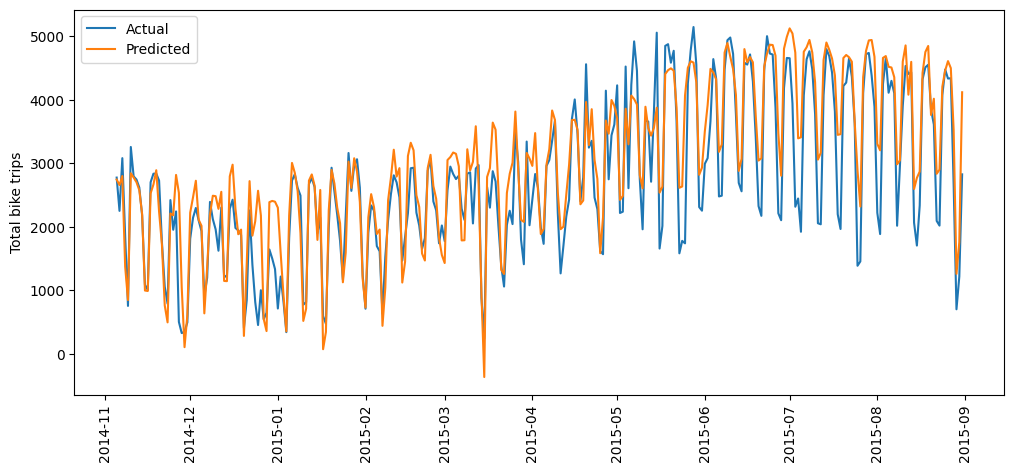

In [12]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

import matplotlib.pyplot as plt

_ = plt.figure(figsize = (12, 5))
_ = plt.plot(Xts.index, yts, label="Actual")
_ = plt.plot(Xts.index, yts_hat, label="Predicted")
_ = plt.legend()
_ = plt.xticks(rotation = 90) 
_ = plt.ylabel("Total bike trips")